In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
train_df = pd.read_csv('../data/raw/train_data.csv')
train_df.replace('-1', np.nan, inplace=True)
train_df.replace(np.float64(-1.0), np.nan, inplace=True)
submission_df = pd.read_csv('../data/raw/submission_data.csv')
submission_df.replace('-1', np.nan, inplace=True)
submission_df.replace(np.float64(-1.0), np.nan, inplace=True)
template_df = pd.read_csv('../data/processed/submission_template.csv')

In [3]:
date_cols = ["launch_date", "date"]  # Adjust as necessary
for col in date_cols:
    train_df[col] = pd.to_datetime(train_df[col], errors='coerce')
    train_df[f"{col}_year"] =  train_df[col].dt.year
    train_df[f"{col}_month"] = train_df[col].dt.month
    train_df[f"{col}_day"] =   train_df[col].dt.day

Vaig a implementar que el test set siguin els top 20% últims llençaments

In [4]:
perc_train_samples = 0.8

launches = train_df.groupby('cluster_nl')['launch_date'].first().reset_index()
launches = launches.sort_values('launch_date')
print(launches)
cutoff = int(len(launches) * perc_train_samples)
cutoff_launch_date = launches.iloc[cutoff]['launch_date']
print(f"Train cutoff: {cutoff_launch_date}")
train_cluster_nls = launches.iloc[:cutoff]['cluster_nl']
test_cluster_nls = launches.iloc[cutoff:]['cluster_nl']

                   cluster_nl launch_date
1190  BRAND_6E6E_COUNTRY_9488  2014-06-01
70    BRAND_03C2_COUNTRY_9891  2014-06-01
1054  BRAND_626D_COUNTRY_8B47  2014-06-01
2505  BRAND_F05A_COUNTRY_3AD0  2014-06-01
2294  BRAND_D724_COUNTRY_445D  2014-06-01
...                       ...         ...
1279  BRAND_740F_COUNTRY_8B47  2022-12-01
1598  BRAND_9259_COUNTRY_FA79  2022-12-01
578   BRAND_3938_COUNTRY_907E  2022-12-01
2440  BRAND_E57A_COUNTRY_4D48  2022-12-01
2635  BRAND_F649_COUNTRY_FA79  2022-12-01

[2716 rows x 2 columns]
Train cutoff: 2020-01-01 00:00:00


In [5]:
print(f"All data shape: {train_df.shape}")
train_data = train_df.loc[train_df['cluster_nl'].isin(train_cluster_nls)]
print(f"Train data shape: {train_data.shape}")
test_data = train_df.loc[train_df['cluster_nl'].isin(test_cluster_nls)]
print(f"Test data shape: {test_data.shape}")

# Separate features and target for training and testing sets
X_train = train_data.drop(columns=['target'])
y_train = train_data['target']

X_test = test_data.drop(columns=['target'])
y_test = test_data['target']

# keep this convenient model to analyze the actual performance metric
metric_df = test_data[['cluster_nl', 'date', 'target']].copy()


All data shape: (118917, 25)
Train data shape: (107392, 25)
Test data shape: (11525, 25)


In [6]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [7]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

In [20]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb_model)
])

# 5. Hyperparameter Tuning
param_grid = {
    "regressor__n_estimators": [300],
    "regressor__learning_rate": [0.03, 0.1, 0.3],
    "regressor__max_depth": [7],
    "regressor__colsample_bytree": [0.7, 0.9, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_mean_squared_error", verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.03, regressor__max_depth=7, regressor__n_estimators=300; total time=   2.4s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.03, regressor__max_depth=7, regressor__n_estimators=300; total time=   2.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.03, regressor__max_depth=7, regressor__n_estimators=300; total time=   2.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=300; total time=   2.1s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=300; total time=   2.2s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.1, regressor__max_depth=7, regressor__n_estimators=300; total time=   2.2s
[CV] END regressor__colsample_bytree=0.7, regressor__learning_rate=0.3, r

In [34]:
results = grid_search.cv_results_
mean_losses = results['mean_test_score']
results_df = pd.DataFrame(results)
# Create a pivot table with row = learning rate, col = regressor__colsample_bytree
pivot_table = results_df.pivot_table(index='param_regressor__learning_rate', columns='param_regressor__colsample_bytree', values='rank_test_score')
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__colsample_bytree,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.059244,0.110271,0.247336,0.011677,0.7,0.03,7,300,"{'regressor__colsample_bytree': 0.7, 'regresso...",-0.238598,-0.217203,-1.040493,-0.498764,0.383159,8
1,2.023108,0.053946,0.234368,0.002382,0.7,0.10,7,300,"{'regressor__colsample_bytree': 0.7, 'regresso...",-0.242536,-0.169682,-0.886766,-0.432995,0.322240,3
2,2.007096,0.150703,0.243336,0.013476,0.7,0.30,7,300,"{'regressor__colsample_bytree': 0.7, 'regresso...",-0.259513,-0.150055,-0.846960,-0.418843,0.306005,1
3,2.359003,0.014338,0.251003,0.005098,0.9,0.03,7,300,"{'regressor__colsample_bytree': 0.9, 'regresso...",-0.245748,-0.227032,-1.023148,-0.498643,0.370960,7
4,2.336726,0.245426,0.247285,0.005868,0.9,0.10,7,300,"{'regressor__colsample_bytree': 0.9, 'regresso...",-0.273556,-0.181052,-0.931184,-0.461931,0.333954,6
5,2.115114,0.108174,0.250670,0.016052,0.9,0.30,7,300,"{'regressor__colsample_bytree': 0.9, 'regresso...",-0.315645,-0.172284,-0.825718,-0.437882,0.280417,4
6,2.543023,0.075782,0.257214,0.007656,1.0,0.03,7,300,"{'regressor__colsample_bytree': 1.0, 'regresso...",-0.256874,-0.253670,-1.026134,-0.512226,0.363390,9
7,2.248806,0.091788,0.245001,0.004082,1.0,0.10,7,300,"{'regressor__colsample_bytree': 1.0, 'regresso...",-0.268691,-0.218997,-0.883993,-0.457227,0.302450,5
8,2.150496,0.062383,0.247999,0.006683,1.0,0.30,7,300,"{'regressor__colsample_bytree': 1.0, 'regresso...",-0.287854,-0.185875,-0.813106,-0.428945,0.274814,2


In [28]:
from helper import compute_metric, _metrics, unaveraged_CYME
def predict_and_measure_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE:  {mse}")
    
    cyme = unaveraged_CYME(metric_df, y_pred)
    print(f"CYME: {cyme}")
    return mse, cyme

mse, cyme = predict_and_measure_performance(best_model, X_test, y_test)


MSE:  0.44678777458992713
CYME: 0.0996407620686559


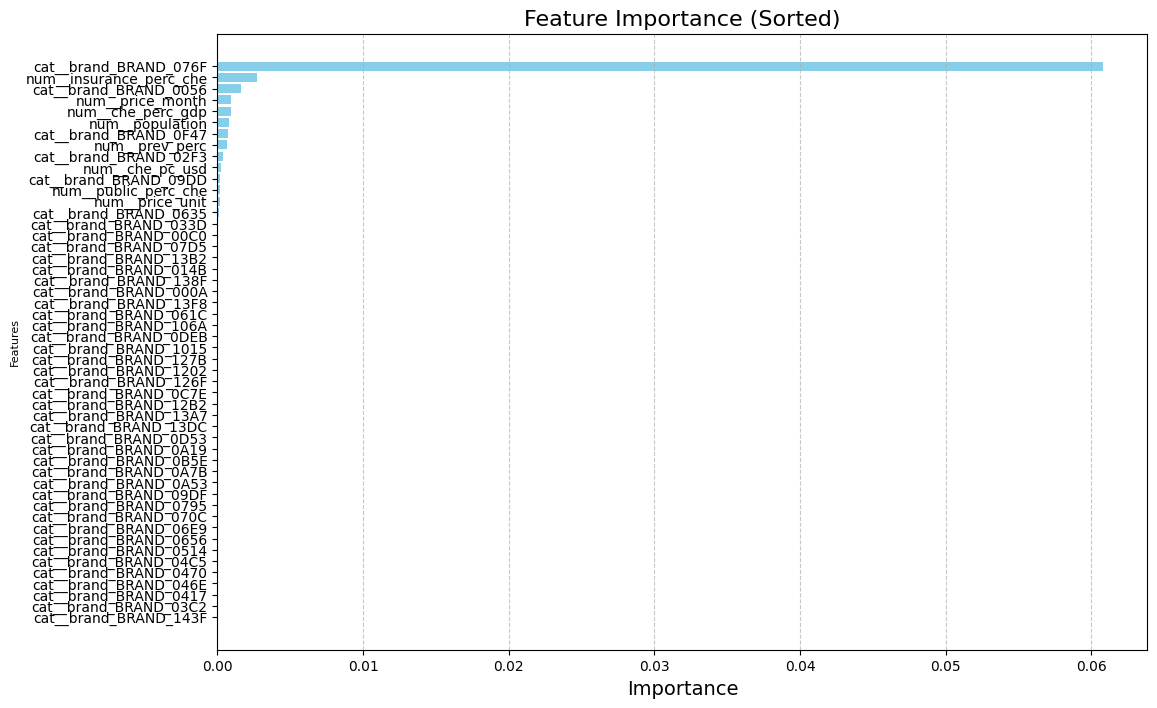

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance


# Extract the XGBRegressor from the pipeline
xgb_regressor = best_model.named_steps["regressor"]

# Handle feature names based on the preprocessor
preprocessor = best_model.named_steps["preprocessor"]

# Get transformed feature names
if hasattr(preprocessor, "get_feature_names_out"):
    feature_names = preprocessor.get_feature_names_out()
else:
    # If the preprocessor does not support this, use generic feature indices
    feature_names = [f"Feature_{i}" for i in range(xgb_regressor.feature_importances_.shape[0])]

# Get feature importances
importance = xgb_regressor.feature_importances_

# Create a DataFrame for sorting and visualization
importance_df = pd.DataFrame({
    "Feature": feature_names[:50],
    "Importance": importance[:50]
}).sort_values(by="Importance", ascending=False)

# Enhanced bar plot
plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=8)
plt.title("Feature Importance (Sorted)", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for highest importance at the top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

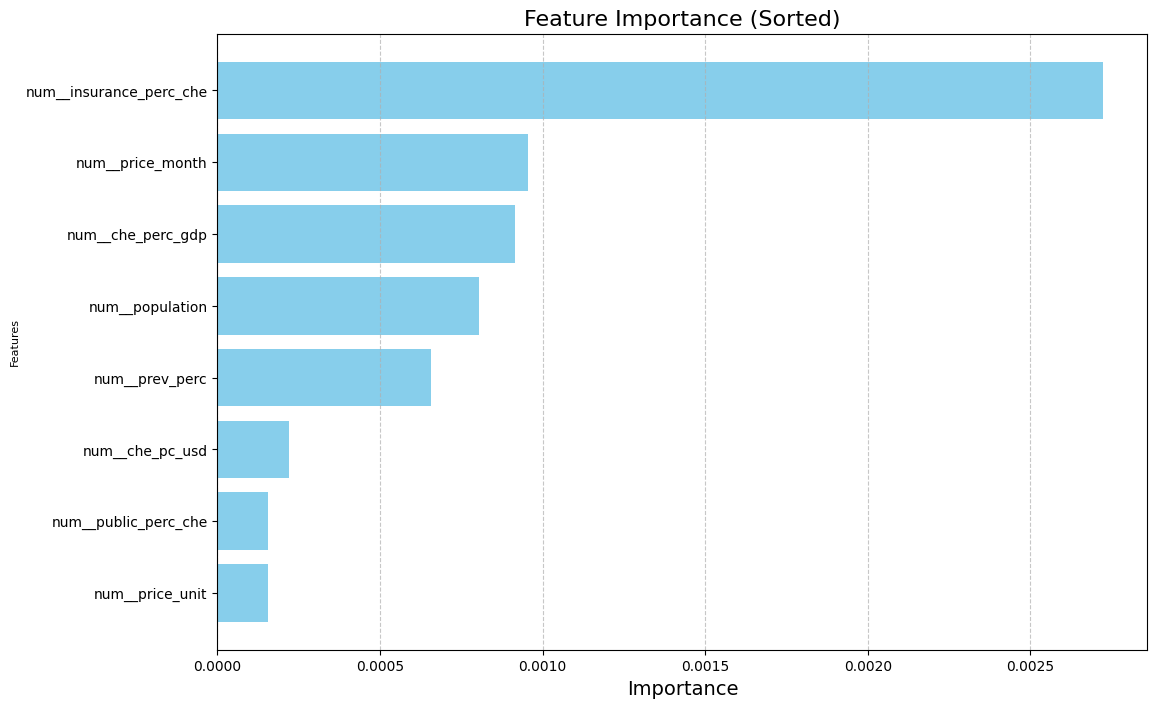

In [ ]:
df_num = importance_df[importance_df.Feature.str.contains('num')]
plt.figure(figsize=(12, 8))
plt.barh(df_num["Feature"], df_num["Importance"], color="skyblue")
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=8)
plt.title("Feature Importance (Sorted)", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for highest importance at the top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
len(importance)

3466

In [ ]:
features_test = submission_df.drop(columns=['target'])
y = submission_df['target']
date_cols = ["launch_date", "date"]  # Adjust as necessary
for col in date_cols:
    features_test[col] = pd.to_datetime(features_test[col], errors='coerce')
    features_test[f"{col}_year"] = features_test[col].dt.year
    features_test[f"{col}_month"] = features_test[col].dt.month
    features_test[f"{col}_day"] = features_test[col].dt.day
features_test.drop(columns=date_cols, inplace=True)

In [ ]:
missing_cols = set(X_train.columns) - set(features_test.columns)
for col in missing_cols:
    features_test[col] = 0 

new_data = features_test[X_train.columns]
predictions = best_model.predict(new_data)

In [ ]:
new_data_with_predictions = new_data.copy()
new_data_with_predictions["prediction"] = predictions
date_cols = ["date"]
for col in date_cols:
    year_col = f"{col}_year"
    month_col = f"{col}_month"
    day_col = f"{col}_day"
    
    if all(c in new_data_with_predictions.columns for c in [year_col, month_col, day_col]):
        new_data_with_predictions[col] = pd.to_datetime(
            dict(year=new_data_with_predictions[year_col], 
                 month=new_data_with_predictions[month_col], 
                 day=new_data_with_predictions[day_col]),
            errors='coerce'
        )
        # Drop the individual year, month, and day columns if necessary
        new_data_with_predictions.drop(columns=[year_col, month_col, day_col], inplace=True)

In [ ]:
final_df = new_data_with_predictions.drop(columns=['brand', 'che_pc_usd', 'che_perc_gdp', 'corporation',
       'country', 'drug_id', 'ind_launch_date', 'indication',
       'insurance_perc_che', 'population', 'prev_perc', 'price_month',
       'price_unit', 'public_perc_che', 'therapeutic_area', 'launch_date_year',
       'launch_date_month', 'launch_date_day', 'launch_date'])

In [ ]:

template_df["date"] = pd.to_datetime(template_df["date"], errors="coerce")
final_df["date"] = pd.to_datetime(final_df["date"], errors="coerce")
filled_df = template_df.merge(
    final_df, 
    on=["date", "cluster_nl"], 
    how="left", 
    suffixes=("", "_pred")
)
filled_df["prediction"] = filled_df["prediction"].fillna(filled_df["prediction_pred"])
filled_df.drop(columns=["prediction_pred"], inplace=True)

In [ ]:
filled_df

,date,cluster_nl,prediction
0,2023-01-01,BRAND_9259_COUNTRY_6B71,1.230247
1,2023-02-01,BRAND_9259_COUNTRY_6B71,1.230247
2,2023-03-01,BRAND_9259_COUNTRY_6B71,1.230247
3,2023-04-01,BRAND_9259_COUNTRY_6B71,1.230247
4,2023-05-01,BRAND_9259_COUNTRY_6B71,1.230247
...,...,...,...
1764,2023-08-01,BRAND_056A_COUNTRY_3536,0.981015
1765,2023-09-01,BRAND_056A_COUNTRY_3536,0.981015
1766,2023-10-01,BRAND_056A_COUNTRY_3536,0.981015
1767,2023-11-01,BRAND_056A_COUNTRY_3536,0.981015


In [ ]:
template_df

,date,cluster_nl,prediction
0,2023-01-01,BRAND_9259_COUNTRY_6B71,NaN
1,2023-02-01,BRAND_9259_COUNTRY_6B71,NaN
2,2023-03-01,BRAND_9259_COUNTRY_6B71,NaN
3,2023-04-01,BRAND_9259_COUNTRY_6B71,NaN
4,2023-05-01,BRAND_9259_COUNTRY_6B71,NaN
...,...,...,...
1764,2023-08-01,BRAND_056A_COUNTRY_3536,NaN
1765,2023-09-01,BRAND_056A_COUNTRY_3536,NaN
1766,2023-10-01,BRAND_056A_COUNTRY_3536,NaN
1767,2023-11-01,BRAND_056A_COUNTRY_3536,NaN


In [ ]:
filled_df.to_csv('../data/outputs/try1.csv',index=False)